In [1]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.DEBUG)

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1605: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


2020-01-21T18:09:09.782 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-01-21T18:09:09.783 DEBUG matplotlib.pyplot.switch_backend Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
# Get stuff in
df_input = pd.read_csv('./TemperatureAnomalyScore.csv', index_col=False, parse_dates=['timestamp'])
df_input['entity']=df_input['deviceid']
# and sort it by timestamp
df_input = df_input.sort_values(by='timestamp')
df_input = df_input.set_index(['entity','timestamp']).dropna()

df_input.head(5)




deviceid  TemperatureKmeansScore  \
entity       timestamp                                                   
04714B60011A 2020-01-19 20:12:00  04714B60011A                0.662106   
             2020-01-19 20:17:00  04714B60011A                0.588443   
             2020-01-19 20:22:00  04714B60011A                0.463848   
             2020-01-19 20:27:00  04714B60011A                0.470927   
             2020-01-19 20:32:00  04714B60011A                0.461369   

                                  TemperatureFFTScore  \
entity       timestamp                                  
04714B60011A 2020-01-19 20:12:00           113.734897   
             2020-01-19 20:17:00           139.645283   
             2020-01-19 20:22:00            83.847681   
             2020-01-19 20:27:00            29.712756   
             2020-01-19 20:32:00            67.705654   

                                  TemperatureSpectralScore  \
entity       timestamp                                       
04714B60011A 2020-01-19 20:12:00                  3.604408   
             2020-01-19 20:17:00                  3.816970   
             2020-01-19 20:22:00                  4.366504   
             2020-01-19 20:27:00                  3.785085   
             2020-01-19 20:32:00                  3.024307   

                                  TemperatureGeneralizedScore  Temperature  
entity       timestamp                                                      
04714B60011A 2020-01-19 20:12:00                 13443.170501         49.7  
             2020-01-19 20:17:00                 82443.617056         49.2  
             2020-01-19 20:22:00                 13483.285199         49.4  
             2020-01-19 20:27:00                  3444.312578         49.5  
             2020-01-19 20:32:00                 13519.768573         49.3

In [3]:
sal = SaliencybasedGeneralizedAnomalyScore('Temperature', 12, 'SaliencyAnomalyScore')
et = sal._build_entity_type(columns = [Column('Temperature',Float())])
sal._entity_type = et
# sal._entity_type = et2
df_input = sal.execute(df=df_input)
df_input.head(3)

2020-01-21T18:09:10.824 DEBUG mmfunctions.anomaly.__init__ Temperature
2020-01-21T18:09:10.827 DEBUG mmfunctions.anomaly.__init__ Saliency
2020-01-21T18:09:10.829 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-01-21T18:09:10.831 DEBUG iotfunctions.util.__init__ Starting trace
2020-01-21T18:09:10.831 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_SaliencybasedGeneralizedAnomalyScore_20200121170910
2020-01-21T18:09:10.832 DEBUG iotfunctions.util.__init__ auto_save None
2020-01-21T18:09:10.832 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-01-21T18:09:10.833 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-01-21T18:09:10.834 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-01-21T18:09:10.835 DEBUG iotfunctions.metadata

deviceid  TemperatureKmeansScore  \
entity       timestamp                                                   
04714B60011A 2020-01-19 20:12:00  04714B60011A                0.662106   
             2020-01-19 20:17:00  04714B60011A                0.588443   
             2020-01-19 20:22:00  04714B60011A                0.463848   

                                  TemperatureFFTScore  \
entity       timestamp                                  
04714B60011A 2020-01-19 20:12:00           113.734897   
             2020-01-19 20:17:00           139.645283   
             2020-01-19 20:22:00            83.847681   

                                  TemperatureSpectralScore  \
entity       timestamp                                       
04714B60011A 2020-01-19 20:12:00                  3.604408   
             2020-01-19 20:17:00                  3.816970   
             2020-01-19 20:22:00                  4.366504   

                                  TemperatureGeneralizedScore  Temperature  \
entity       timestamp                                                       
04714B60011A 2020-01-19 20:12:00                 13443.170501         49.7   
             2020-01-19 20:17:00                 82443.617056         49.2   
             2020-01-19 20:22:00                 13483.285199         49.4   

                                  SaliencyAnomalyScore  
entity       timestamp                                  
04714B60011A 2020-01-19 20:12:00             75.296014  
             2020-01-19 20:17:00             68.731082  
             2020-01-19 20:22:00             62.166150

In [4]:
sps = SpectralAnomalyScore('Temperature', 12, 'TemperatureSpectralScore2')
et = sps._build_entity_type(columns = [Column('Temperature',Float())])
sps._entity_type = et
# sal._entity_type = et2
df_input = sps.execute(df=df_input)
df_input.head(3)

2020-01-21T18:09:11.812 DEBUG mmfunctions.anomaly.__init__ Temperature
2020-01-21T18:09:11.815 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-01-21T18:09:11.818 DEBUG iotfunctions.util.__init__ Starting trace
2020-01-21T18:09:11.820 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_SpectralAnomalyScore_20200121170911
2020-01-21T18:09:11.823 DEBUG iotfunctions.util.__init__ auto_save None
2020-01-21T18:09:11.825 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-01-21T18:09:11.827 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-01-21T18:09:11.828 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-01-21T18:09:11.830 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:None
Functions:
Granularities:
No

deviceid  TemperatureKmeansScore  \
entity       timestamp                                                   
04714B60011A 2020-01-19 20:12:00  04714B60011A                0.662106   
             2020-01-19 20:17:00  04714B60011A                0.588443   
             2020-01-19 20:22:00  04714B60011A                0.463848   

                                  TemperatureFFTScore  \
entity       timestamp                                  
04714B60011A 2020-01-19 20:12:00           113.734897   
             2020-01-19 20:17:00           139.645283   
             2020-01-19 20:22:00            83.847681   

                                  TemperatureSpectralScore  \
entity       timestamp                                       
04714B60011A 2020-01-19 20:12:00                  3.604408   
             2020-01-19 20:17:00                  3.816970   
             2020-01-19 20:22:00                  4.366504   

                                  TemperatureGeneralizedScore  Temperature  \
entity       timestamp                                                       
04714B60011A 2020-01-19 20:12:00                 13443.170501         49.7   
             2020-01-19 20:17:00                 82443.617056         49.2   
             2020-01-19 20:22:00                 13483.285199         49.4   

                                  SaliencyAnomalyScore  \
entity       timestamp                                   
04714B60011A 2020-01-19 20:12:00             75.296014   
             2020-01-19 20:17:00             68.731082   
             2020-01-19 20:22:00             62.166150   

                                  TemperatureSpectralScore2  
entity       timestamp                                       
04714B60011A 2020-01-19 20:12:00                  45.520282  
             2020-01-19 20:17:00                  38.638068  
             2020-01-19 20:22:00                  31.755855

In [5]:
EngineLogging.configure_console_logging(logging.INFO)

df_input2 = df_input.loc[['04714B60011A']]
df_input2.reset_index(level=[0], inplace=True)

Text(0, 0.5, 'Temperature-50')

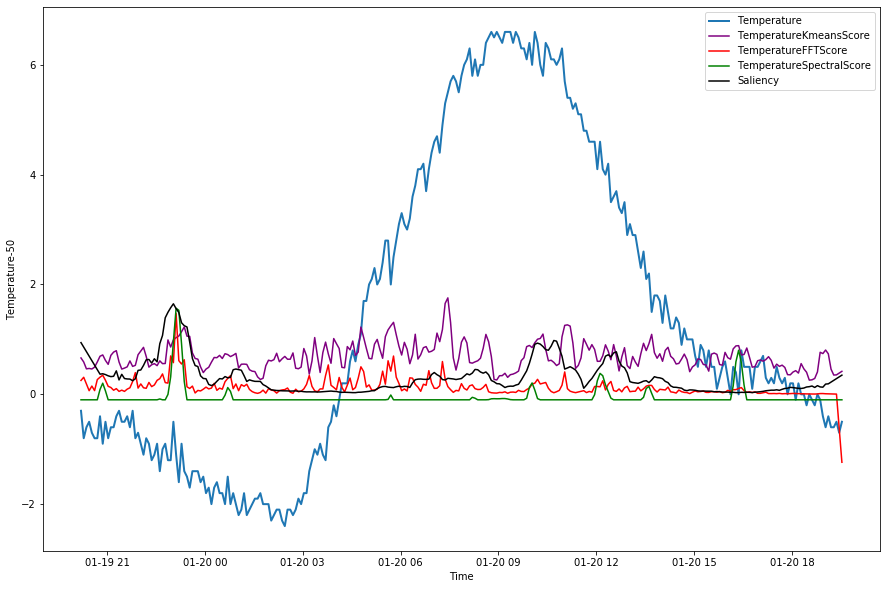

In [7]:


fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.plot(df_input2.index, df_input['Temperature']-50,linewidth=2,label='Temperature')
ax.plot(df_input2.index, df_input['TemperatureKmeansScore'], color='purple',label='TemperatureKmeansScore')
ax.plot(df_input2.index, df_input['TemperatureFFTScore']/450, color='red',label='TemperatureFFTScore')
ax.plot(df_input2.index, -np.minimum(df_input['TemperatureSpectralScore2']/30,0.1), color='green',
        label='TemperatureSpectralScore')
ax.plot(df_input2.index, df_input['SaliencyAnomalyScore']/80,color='black',label='Saliency')
#ax.plot(df_input.index, np.minimum(df_input['TemperatureGeneralizedScore']/10000,10), color='orange',
#        label='TemperatureGeneralizedScore')

ax.legend()
#ax.set_ylim(60, 90)
ax.set_xlabel('Time')
ax.set_ylabel('Temperature-50')

#### Next steps

* Get the anomaly generator working
* Generate randomized timeseries data with anomalies
* Slice it and label the slices by anomaly type (None, Near vertical line, flat line, ...)
* Apply spectral residual transformation (aka Saliency) to the slices
* Train a plain CNN to classify anomalies - see also SpectralResidualCNN